In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import metrics
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import decomposition
import random
from scipy import stats

In [2]:
data = pd.read_csv("C:\Datasets\processed.cleveland.data.txt",header=None,na_values=["?"])
data.shape

(303, 14)

In [3]:
data.rename(columns={0: 'age', 1: 'sex', 2: 'cp', 3: 'trestbps', 4: 'chol', 
                      5: 'fbs', 6: 'restecg', 7: 'thalach', 8: 'exang', 9: 'oldpeak', 
                      10: 'slope', 11: 'ca', 12: 'thal', 13: 'num'}, inplace=True)

In [4]:
data.head(10)
#Note: some variables are categorical, where the levels are represented by numeric integers

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
5,56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
6,62,0,4,140,268,0,2,160,0,3.6,3,2,3,3
7,57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
8,63,1,4,130,254,0,2,147,0,1.4,2,1,7,2
9,53,1,4,140,203,1,2,155,1,3.1,3,0,7,1


In [5]:
data.describe(include="all").T
#We see that "ca" has 4 missing values and "thal" has 2 missing values.

,count,mean,std,min,25%,50%,75%,max
age,303,54.438944,9.038662,29,48.0,56.0,61.0,77.0
sex,303,0.679868,0.467299,0,0.0,1.0,1.0,1.0
cp,303,3.158416,0.960126,1,3.0,3.0,4.0,4.0
trestbps,303,131.689769,17.599748,94,120.0,130.0,140.0,200.0
chol,303,246.693069,51.776918,126,211.0,241.0,275.0,564.0
fbs,303,0.148515,0.356198,0,0.0,0.0,0.0,1.0
restecg,303,0.990099,0.994971,0,0.0,1.0,2.0,2.0
thalach,303,149.607261,22.875003,71,133.5,153.0,166.0,202.0
exang,303,0.326733,0.469794,0,0.0,0.0,1.0,1.0
oldpeak,303,1.039604,1.161075,0,0.0,0.8,1.6,6.2


In [6]:
#These are the rows where there are missing values for the "ca" variable.
data[data.ca.isnull()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7,1
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3,0


In [7]:
#These are the rows where there are missing values for the "thal" variable.
data[data.thal.isnull()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53,0,3,128,216,0,2,115,0,0,1,0,NaN,0
266,52,1,4,128,204,1,0,156,1,1,2,0,NaN,2


The missing values will be replaced by the mean of each of the two variables. However, we will perform this step in a sightly more intelligent manner than simply replacing the missing value with the mean. Since there are 5 classes in our data, we will compute the mean value for the variables "ca" and "thal", for each of the 5 classes. Then, the missing values will be replaced by the mean value that corresponds to that class label for that particular observation.

In [8]:
data.groupby("num").describe(include="all")
#"Num" is our class variable. this gives us the mean of each of our variables, broken down by the 5 classes.

age          ca        chol          cp       exang  \
num                                                                     
0   count  164.000000  161.000000  164.000000  164.000000  164.000000   
    mean    52.585366    0.273292  242.640244    2.792683    0.140244   
    std      9.511957    0.632333   53.456580    0.916620    0.348303   
    min     29.000000    0.000000  126.000000    1.000000    0.000000   
    25%     44.750000    0.000000  208.750000    2.000000    0.000000   
    50%     52.000000    0.000000  234.500000    3.000000    0.000000   
    75%     59.000000    0.000000  267.250000    3.000000    0.000000   
    max     76.000000    3.000000  564.000000    4.000000    1.000000   
1   count   55.000000   54.000000   55.000000   55.000000   55.000000   
    mean    55.381818    0.740741  249.109091    3.345455    0.454545   
    std      8.001136    0.872757   40.751129    1.004032    0.502519   
    min     35.000000    0.000000  149.000000    1.000000    0.000000   
    25%     50.500000    0.000000  226.000000    3.000000    0.000000   
    50%     57.000000    1.000000  249.000000    4.000000    0.000000   
    75%     60.500000    1.000000  275.500000    4.000000    1.000000   
    max     70.000000    3.000000  335.000000    4.000000    1.000000   
2   count   36.000000   36.000000   36.000000   36.000000   36.000000   
    mean    58.027778    1.222222  259.277778    3.750000    0.611111   
    std      7.220946    0.959497   53.745225    0.649175    0.494413   
    min     42.000000    0.000000  169.000000    1.000000    0.000000   
    25%     55.750000    0.750000  223.250000    4.000000    0.000000   
    50%     59.000000    1.000000  254.000000    4.000000    1.000000   
    75%     62.250000    2.000000  293.250000    4.000000    1.000000   
    max     69.000000    3.000000  409.000000    4.000000    1.000000   
3   count   35.000000   35.000000   35.000000   35.000000   35.000000   
    mean    56.000000    1.457143  246.457143    3.771429    0.657143   
    std      7.780065    1.010034   51.741065    0.546955    0.481594   
    min     39.000000    0.000000  131.000000    2.000000    0.000000   
    25%     51.500000    1.000000  209.000000    4.000000    0.000000   
    50%     56.000000    2.000000  256.000000    4.000000    1.000000   
    75%     62.000000    2.000000  281.500000    4.000000    1.000000   
    max     70.000000    3.000000  353.000000    4.000000    1.000000   
4   count   13.000000   13.000000   13.000000   13.000000   13.000000   
    mean    59.692308    1.692308  253.384615    3.692308    0.461538   
    std      9.419701    1.250641   66.287931    0.854850    0.518875   
    min     38.000000    0.000000  166.000000    1.000000    0.000000   
    25%     57.000000    1.000000  212.000000    4.000000    0.000000   
    50%     60.000000    2.000000  231.000000    4.000000    0.000000   
    75%     64.000000    3.000000  289.000000    4.000000    1.000000   
    max     77.000000    3.000000  407.000000    4.000000    1.000000   

                  fbs     oldpeak     restecg         sex       slope  \
num                                                                     
0   count  164.000000  164.000000  164.000000  164.000000  164.000000   
    mean     0.140244    0.586585    0.835366    0.560976    1.408537   
    std      0.348303    0.781734    0.986270    0.497788    0.594598   
    min      0.000000    0.000000    0.000000    0.000000    1.000000   
    25%      0.000000    0.000000    0.000000    0.000000    1.000000   
    50%      0.000000    0.200000    0.000000    1.000000    1.000000   
    75%      0.000000    1.025000    2.000000    1.000000    2.000000   
    max      1.000000    4.200000    2.000000    1.000000    3.000000   
1   count   55.000000   55.000000   55.000000   55.000000   55.000000   
    mean     0.072727    1.005455    1.163636    0.836364    1.636364   
    std      0.262082    0.993389    0.995613    0.373355    0.556565   
  

In [9]:
#break up the data into 5 subsets, by class label.
#this will make it easier to replace the missing values by the mean value for a particular class label
data_num0 = data[data.num==0]
data_num1 = data[data.num==1]
data_num2 = data[data.num==2]
data_num3 = data[data.num==3]
data_num4 = data[data.num==4]

The variable "ca" is the number of major vessels colored by fluoroscopy. Its values are numeric integers in the range of [0,3].

All of the missing values for the "ca" variable are have a class label of either 0 or 1.

In [10]:
ca_num0=round(data_num0.ca.mean())
ca_num0
#the average value for "ca" when the class label is 0, is 0.27329

0.0

In [11]:
#here we replace those missing values for the "ca" variable that have a class label of 0, 
#with the mean "ca" value for that class label
data_num0.ca.fillna(ca_num0, axis=0, inplace=True)

C:\Users\Thavaselvi\Anaconda\lib\site-packages\pandas\core\generic.py:2602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [12]:
#here we do the same thing for the missing "ca" values which have a class label of 1.
ca_num1=round(data_num1.ca.mean())
ca_num1

1.0

In [13]:
#replace missing "ca" values which have a class label of 1
data_num1.ca.fillna(ca_num1, axis=0, inplace=True)

The variable "thal" refers to a Thalium Stress Test that was performed on each of the patients. The three values for this variable are categorical, and are represented by the integers 3, 6, and 7. (3=Normal; 6=Fixed Defect; and 7=Reversible Defect).

All of the missing values for the "thal" variable are have a class label of either 0 or 2.

In [14]:
#for the class label 0, the variable "thal" has a mean of 3.7, 
#Out of the three possible values for the "thal" variable, 3.7 is closest to 3.
thal_num0=data_num0.thal.mean()
int(thal_num0)

3

In [15]:
#here we replace the missing "thal" values which have a class label of 0.
data_num0.thal.fillna(int(thal_num0), axis=0, inplace=True)

In [16]:
thal_num2=data_num2.thal.mean()
int(thal_num2)

6

In [17]:
#here we replace the missing "thal" values which have a class label of 2.
data_num2.thal.fillna(int(thal_num2), axis=0, inplace=True)

All missing values are now replaced by their mean value, corresponding to their particular class label.
We can now restack each of the dataX dataframes into one whole dataframe (as they were originally).

In [18]:
frames = [data_num0, data_num1, data_num2, data_num3, data_num4]
data2 = pd.concat(frames)

In [19]:
data2=data2.sort_index()

In [20]:
data2.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
5,56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
6,62,0,4,140,268,0,2,160,0,3.6,3,2,3,3
7,57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
8,63,1,4,130,254,0,2,147,0,1.4,2,1,7,2
9,53,1,4,140,203,1,2,155,1,3.1,3,0,7,1


In [21]:
data2.shape

(303, 14)

In [22]:
data2.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
age,303,54.438944,9.038662,29,48.0,56.0,61.0,77.0
sex,303,0.679868,0.467299,0,0.0,1.0,1.0,1.0
cp,303,3.158416,0.960126,1,3.0,3.0,4.0,4.0
trestbps,303,131.689769,17.599748,94,120.0,130.0,140.0,200.0
chol,303,246.693069,51.776918,126,211.0,241.0,275.0,564.0
fbs,303,0.148515,0.356198,0,0.0,0.0,0.0,1.0
restecg,303,0.990099,0.994971,0,0.0,1.0,2.0,2.0
thalach,303,149.607261,22.875003,71,133.5,153.0,166.0,202.0
exang,303,0.326733,0.469794,0,0.0,0.0,1.0,1.0
oldpeak,303,1.039604,1.161075,0,0.0,0.8,1.6,6.2


In [23]:
#write this datafile to csv for future reference if necessary.
data2.to_csv("data2.csv",index=False)

Now we can replace the integers that are being used as labels for the categorical variables, with the actual categorical labels.

In [24]:
data2.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [25]:
data2.loc[data2.sex == 0, 'sex'] = 'female'
data2.loc[data2.sex == 1, 'sex'] = 'male'
data2.loc[data2.cp == 1, 'cp'] = 'typical_angina'
data2.loc[data2.cp == 2, 'cp'] = 'atypical_angina'
data2.loc[data2.cp == 3, 'cp'] = 'non_anginal_pain'
data2.loc[data2.cp == 4, 'cp'] = 'asymptomatic'
data2.loc[data2.fbs == 0, 'fbs'] = '<=120mg/dl'
data2.loc[data2.fbs == 1, 'fbs'] = '>120mg/dl'
data2.loc[data2.restecg == 0, 'restecg'] = 'normal'
data2.loc[data2.restecg == 1, 'restecg'] = 'STT_wave_abnormality'
data2.loc[data2.restecg == 2, 'restecg'] = 'left_ventricular_hypertrophy'
data2.loc[data2.exang == 0, 'exang'] = 'no'
data2.loc[data2.exang == 1, 'exang'] = 'yes'
data2.loc[data2.slope == 1, 'slope'] = 'upsloping'
data2.loc[data2.slope == 2, 'slope'] = 'flat'
data2.loc[data2.slope == 3, 'slope'] = 'downsloping'
data2.loc[data2.thal == 3, 'thal'] = 'normal'
data2.loc[data2.thal == 6, 'thal'] = 'fixed_defect'
data2.loc[data2.thal == 7, 'thal'] = 'reversable_defect'

In [26]:
data2.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,male,typical_angina,145,233,>120mg/dl,left_ventricular_hypertrophy,150,no,2.3,downsloping,0,fixed_defect,0
1,67,male,asymptomatic,160,286,<=120mg/dl,left_ventricular_hypertrophy,108,yes,1.5,flat,3,normal,2
2,67,male,asymptomatic,120,229,<=120mg/dl,left_ventricular_hypertrophy,129,yes,2.6,flat,2,reversable_defect,1
3,37,male,non_anginal_pain,130,250,<=120mg/dl,normal,187,no,3.5,downsloping,0,normal,0
4,41,female,atypical_angina,130,204,<=120mg/dl,left_ventricular_hypertrophy,172,no,1.4,upsloping,0,normal,0


In [27]:
data2.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,303,NaN,NaN,NaN,54.43894,9.038662,29,48,56,61,77
sex,303,2,male,206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cp,303,4,asymptomatic,144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trestbps,303,NaN,NaN,NaN,131.6898,17.59975,94,120,130,140,200
chol,303,NaN,NaN,NaN,246.6931,51.77692,126,211,241,275,564
fbs,303,2,<=120mg/dl,258,NaN,NaN,NaN,NaN,NaN,NaN,NaN
restecg,303,3,normal,151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thalach,303,NaN,NaN,NaN,149.6073,22.875,71,133.5,153,166,202
exang,303,2,no,204,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldpeak,303,NaN,NaN,NaN,1.039604,1.161075,0,0,0.8,1.6,6.2


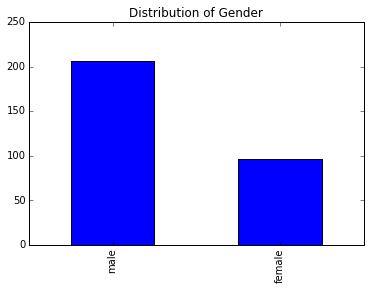

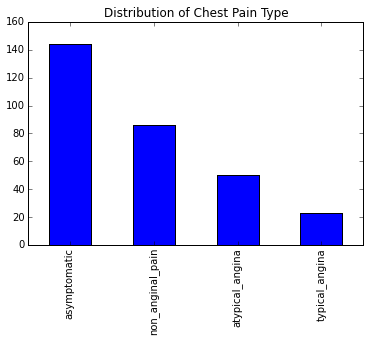

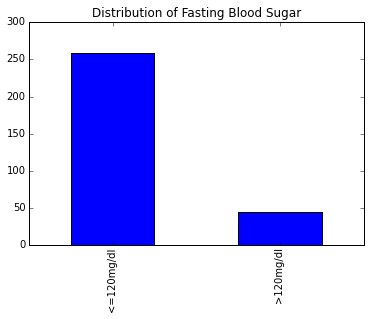

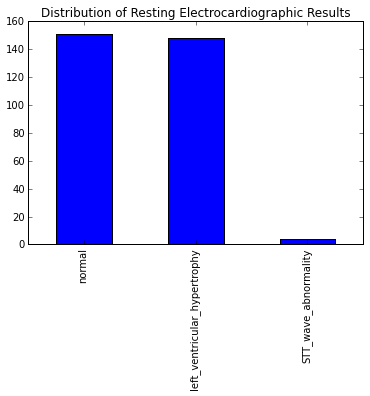

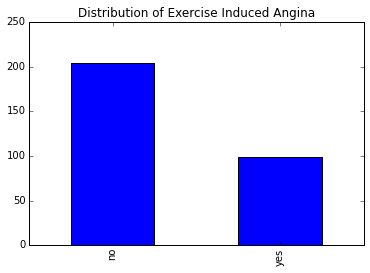

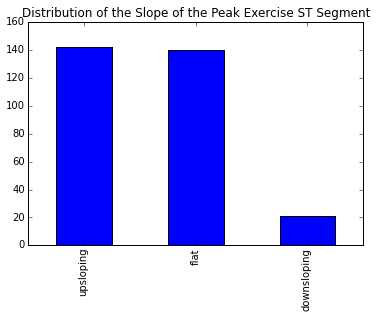

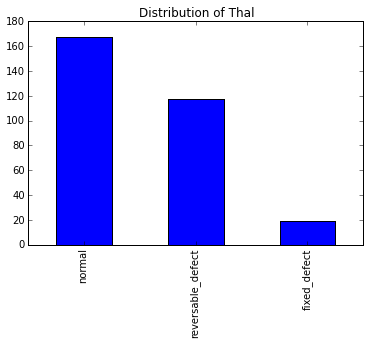

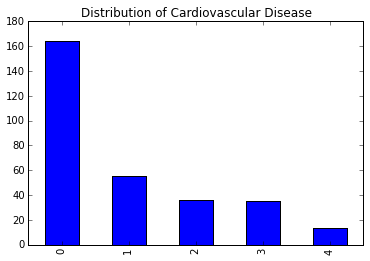

In [28]:
plt.show(data2["sex"].value_counts().plot(kind='bar', title="Distribution of Gender"))
plt.show(data2["cp"].value_counts().plot(kind='bar', title="Distribution of Chest Pain Type"))
plt.show(data2["fbs"].value_counts().plot(kind='bar', title="Distribution of Fasting Blood Sugar"))
plt.show(data2["restecg"].value_counts().plot(kind='bar', title="Distribution of Resting Electrocardiographic Results"))
plt.show(data2["exang"].value_counts().plot(kind='bar', title="Distribution of Exercise Induced Angina"))
plt.show(data2["slope"].value_counts().plot(kind='bar', title="Distribution of the Slope of the Peak Exercise ST Segment"))
plt.show(data2["thal"].value_counts().plot(kind='bar', title="Distribution of Thal"))
plt.show(data2["num"].value_counts().plot(kind='bar', title="Distribution of Cardiovascular Disease"))

In [29]:
#write this datafile (with categorical labels) to csv for future reference if necessary.
data2.to_csv("data2_cat.csv",index=False)

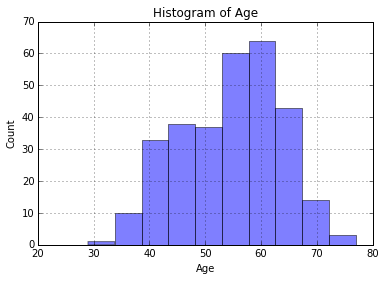

In [30]:
plt.hist(data2["age"], bins=10, alpha=0.5)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Histogram of Age")
plt.grid(True)
plt.show()

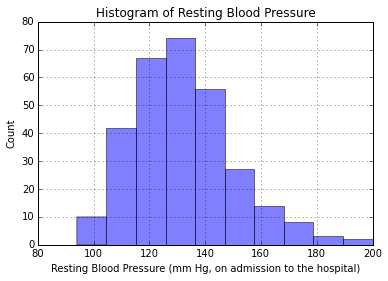

In [31]:
plt.hist(data2["trestbps"], bins=10, alpha=0.5)
plt.xlabel("Resting Blood Pressure (mm Hg, on admission to the hospital)")
plt.ylabel("Count")
plt.title("Histogram of Resting Blood Pressure")
plt.grid(True)
plt.show()

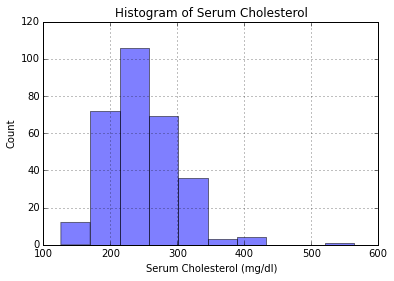

In [32]:
plt.hist(data2["chol"], bins=10, alpha=0.5)
plt.xlabel("Serum Cholesterol (mg/dl)")
plt.ylabel("Count")
plt.title("Histogram of Serum Cholesterol")
plt.grid(True)
plt.show()

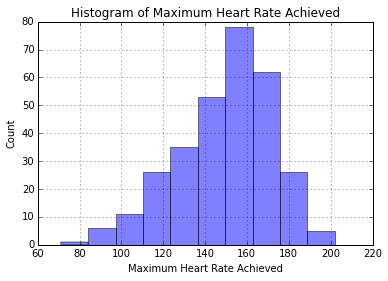

In [33]:
plt.hist(data2["thalach"], bins=10, alpha=0.5)
plt.xlabel("Maximum Heart Rate Achieved")
plt.ylabel("Count")
plt.title("Histogram of Maximum Heart Rate Achieved")
plt.grid(True)
plt.show()

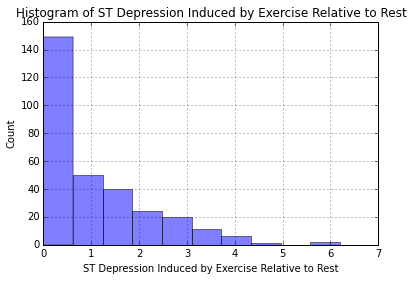

In [34]:
plt.hist(data2["oldpeak"], bins=10, alpha=0.5)
plt.xlabel("ST Depression Induced by Exercise Relative to Rest")
plt.ylabel("Count")
plt.title("Histogram of ST Depression Induced by Exercise Relative to Rest")
plt.grid(True)
plt.show()

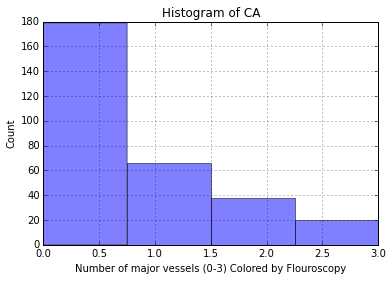

In [35]:
plt.hist(data2["ca"], bins=4, alpha=0.5)
plt.xlabel("Number of major vessels (0-3) Colored by Flouroscopy")
plt.ylabel("Count")
plt.title("Histogram of CA")
plt.grid(True)
plt.show()

In [36]:
data2.groupby("num").describe(include="all")

age          ca        chol                cp exang  \
num                                                                      
0   count   164.000000  164.000000  164.000000               164   164   
    unique         NaN         NaN         NaN                 4     2   
    top            NaN         NaN         NaN  non_anginal_pain    no   
    freq           NaN         NaN         NaN                68   141   
    mean     52.585366    0.268293  242.640244               NaN   NaN   
    std       9.511957    0.627563   53.456580               NaN   NaN   
    min      29.000000    0.000000  126.000000               NaN   NaN   
    25%      44.750000    0.000000  208.750000               NaN   NaN   
    50%      52.000000    0.000000  234.500000               NaN   NaN   
    75%      59.000000    0.000000  267.250000               NaN   NaN   
    max      76.000000    3.000000  564.000000               NaN   NaN   
1   count    55.000000   55.000000   55.000000                55    55   
    unique         NaN         NaN         NaN                 4     2   
    top            NaN         NaN         NaN      asymptomatic    no   
    freq           NaN         NaN         NaN                35    30   
    mean     55.381818    0.745455  249.109091               NaN   NaN   
    std       8.001136    0.865345   40.751129               NaN   NaN   
    min      35.000000    0.000000  149.000000               NaN   NaN   
    25%      50.500000    0.000000  226.000000               NaN   NaN   
    50%      57.000000    1.000000  249.000000               NaN   NaN   
    75%      60.500000    1.000000  275.500000               NaN   NaN   
    max      70.000000    3.000000  335.000000               NaN   NaN   
2   count    36.000000   36.000000   36.000000                36    36   
    unique         NaN         NaN         NaN                 4     2   
    top            NaN         NaN         NaN      asymptomatic   yes   
    freq           NaN         NaN         NaN                30    22   
    mean     58.027778    1.222222  259.277778               NaN   NaN   
    std       7.220946    0.959497   53.745225               NaN   NaN   
    min      42.000000    0.000000  169.000000               NaN   NaN   
    25%      55.750000    0.750000  223.250000               NaN   NaN   
    50%      59.000000    1.000000  254.000000               NaN   NaN   
    75%      62.250000    2.000000  293.250000               NaN   NaN   
    max      69.000000    3.000000  409.000000               NaN   NaN   
3   count    35.000000   35.000000   35.000000                35    35   
    unique         NaN         NaN         NaN                 3     2   
    top            NaN         NaN         NaN      asymptomatic   yes   
    freq           NaN         NaN         NaN                29    23   
    mean     56.000000    1.457143  246.457143               NaN   NaN   
    std       7.780065    1.010034   51.741065               NaN   NaN   
    min      39.000000    0.000000  131.000000               NaN   NaN   
    25%      51.500000    1.000000  209.000000               NaN   NaN   
    50%      56.000000    2.000000  256.000000               NaN   NaN   
    75%      62.000000    2.000000  281.500000               NaN   NaN   
    max      70.000000    3.000000  353.000000               NaN   NaN   
4   count    13.000000   13.000000   13.000000                13    13   
    unique         NaN         NaN         NaN                 3     2   
    top            NaN         NaN         NaN      asymptomatic    no   
    freq           NaN         NaN         NaN                11     7   
    mean     59.692308    1.692308  253.384615               NaN   NaN   
    std       9.419701    1.250641   66.287931               NaN   NaN   
    min      38.000000    0.000000  166.000000               NaN   NaN   
    25%      57.000000    1.000000  212.000000               NaN   NaN   
    50%      60.000000 

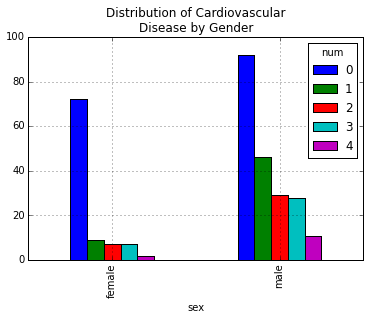

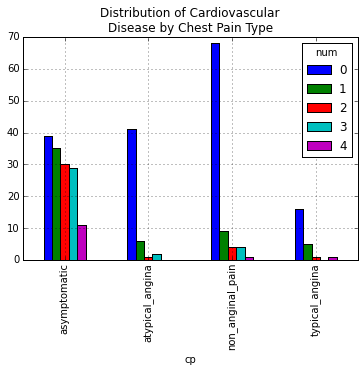

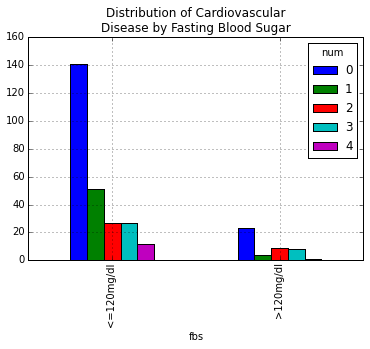

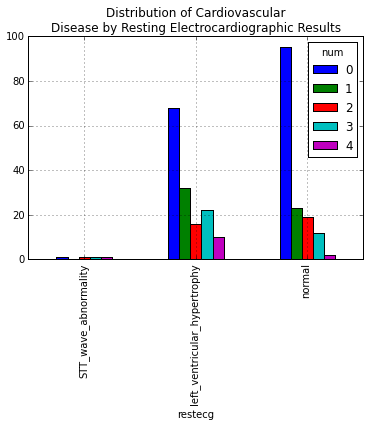

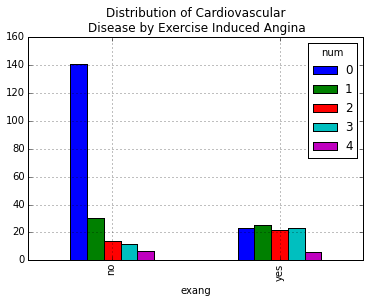

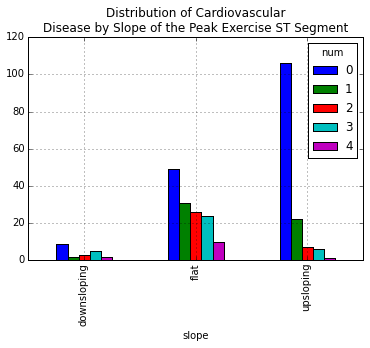

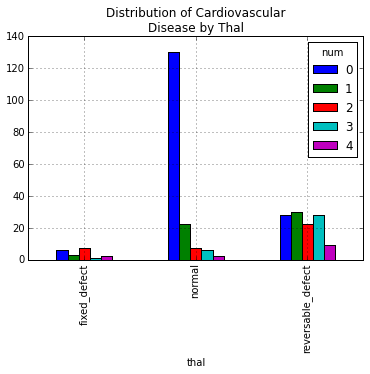

In [37]:
sn = pd.crosstab(data2["sex"], data2["num"])
cn = pd.crosstab(data2["cp"], data2["num"])
fn = pd.crosstab(data2["fbs"], data2["num"])
rn = pd.crosstab(data2["restecg"], data2["num"])
en = pd.crosstab(data2["exang"], data2["num"])
ln = pd.crosstab(data2["slope"], data2["num"])
tn = pd.crosstab(data2["thal"], data2["num"])

sn.plot(kind="bar",grid = True, title="Distribution of Cardiovascular\nDisease by Gender")
cn.plot(kind="bar",grid = True, title="Distribution of Cardiovascular\nDisease by Chest Pain Type")
fn.plot(kind="bar",grid = True, title="Distribution of Cardiovascular\nDisease by Fasting Blood Sugar")
rn.plot(kind="bar",grid = True, title="Distribution of Cardiovascular\nDisease by Resting Electrocardiographic Results")
en.plot(kind="bar",grid = True, title="Distribution of Cardiovascular\nDisease by Exercise Induced Angina")
ln.plot(kind="bar",grid = True, title="Distribution of Cardiovascular\nDisease by Slope of the Peak Exercise ST Segment")
tn.plot(kind="bar",grid = True, title="Distribution of Cardiovascular\nDisease by Thal")


In [38]:
data2.corr() #numeric features only

,age,trestbps,chol,thalach,oldpeak,ca,num
age,1.000000,0.284946,0.208950,-0.393806,0.203805,0.361064,0.222853
trestbps,0.284946,1.000000,0.130120,-0.045351,0.189171,0.097652,0.157754
chol,0.208950,0.130120,1.000000,-0.003432,0.046564,0.123824,0.070909
thalach,-0.393806,-0.045351,-0.003432,1.000000,-0.343085,-0.266890,-0.415040
oldpeak,0.203805,0.189171,0.046564,-0.343085,1.000000,0.298386,0.504092
ca,0.361064,0.097652,0.123824,-0.266890,0.298386,1.000000,0.521475
num,0.222853,0.157754,0.070909,-0.415040,0.504092,0.521475,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x09D54E90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11B8A470>]], dtype=object)

C:\Users\Thavaselvi\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


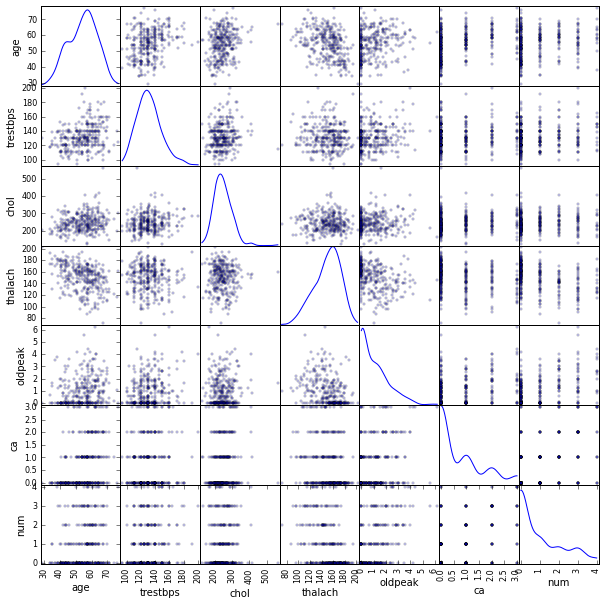

In [39]:
#Scatter matrix (of numeric variables only)
scatter_matrix(data2, alpha=0.2, figsize=(10,10), diagonal='kde')

In [40]:
#convert categorical variables into dummy variables to see entire correlation matrix

In [41]:
data3=pd.get_dummies(data2)
data3.head().T

,0,1,2,3,4
age,63.0,67.0,67.0,37.0,41.0
trestbps,145.0,160.0,120.0,130.0,130.0
chol,233.0,286.0,229.0,250.0,204.0
thalach,150.0,108.0,129.0,187.0,172.0
oldpeak,2.3,1.5,2.6,3.5,1.4
ca,0.0,3.0,2.0,0.0,0.0
num,0.0,2.0,1.0,0.0,0.0
sex_female,0.0,0.0,0.0,0.0,1.0
sex_male,1.0,1.0,1.0,1.0,0.0
cp_asymptomatic,0.0,1.0,1.0,0.0,0.0


In [42]:
#this will let us see the correlation matrix for all variables
pd.set_option('display.max_columns', None)
data3.corr()

,age,trestbps,chol,thalach,oldpeak,ca,num,sex_female,sex_male,cp_asymptomatic,cp_atypical_angina,cp_non_anginal_pain,cp_typical_angina,fbs_<=120mg/dl,fbs_>120mg/dl,restecg_STT_wave_abnormality,restecg_left_ventricular_hypertrophy,restecg_normal,exang_no,exang_yes,slope_downsloping,slope_flat,slope_upsloping,thal_fixed_defect,thal_normal,thal_reversable_defect
age,1.000000,0.284946,0.208950,-0.393806,0.203805,0.361064,0.222853,0.097542,-0.097542,0.135337,-0.151684,-0.051714,0.045438,-0.118530,0.118530,0.084097,0.138313,-0.157474,-0.091661,0.091661,0.028487,0.170596,-0.184938,0.056814,-0.130378,0.104902
trestbps,0.284946,1.000000,0.130120,-0.045351,0.189171,0.097652,0.157754,0.064456,-0.064456,0.027710,-0.083234,-0.050127,0.149737,-0.175340,0.175340,0.057995,0.139000,-0.152203,-0.064762,0.064762,0.120930,0.021638,-0.083165,0.070423,-0.138290,0.106210
chol,0.208950,0.130120,1.000000,-0.003432,0.046564,0.123824,0.070909,0.199915,-0.199915,0.070343,-0.016453,-0.033223,-0.053021,-0.009841,0.009841,0.033691,0.166100,-0.173748,-0.061310,0.061310,-0.047652,0.043538,-0.019245,-0.104597,-0.000994,0.053100
thalach,-0.393806,-0.045351,-0.003432,1.000000,-0.343085,-0.266890,-0.415040,0.048663,-0.048663,-0.371989,0.249415,0.159876,0.079683,0.007854,-0.007854,-0.120829,-0.069061,0.096625,0.378103,-0.378103,-0.056191,-0.418573,0.446787,-0.151731,0.283753,-0.214326
oldpeak,0.203805,0.189171,0.046564,-0.343085,1.000000,0.298386,0.504092,-0.102173,0.102173,0.274218,-0.277513,-0.126339,0.086959,-0.005747,0.005747,0.168172,0.094202,-0.132567,-0.288223,0.288223,0.394253,0.310986,-0.511356,0.101558,-0.345261,0.302145
ca,0.361064,0.097652,0.123824,-0.266890,0.298386,1.000000,0.521475,-0.088531,0.088531,0.276473,-0.155775,-0.143956,-0.057923,-0.149329,0.149329,0.041356,0.129841,-0.139248,-0.150961,0.150961,-0.027878,0.168054,-0.153710,0.077881,-0.258610,0.225414
num,0.222853,0.157754,0.070909,-0.415040,0.504092,0.521475,1.000000,-0.224469,0.224469,0.490494,-0.238240,-0.284135,-0.107265,-0.059186,0.059186,0.123792,0.168387,-0.196601,-0.397057,0.397057,0.119900,0.344230,-0.404938,0.113117,-0.511403,0.466119
sex_female,0.097542,0.064456,0.199915,0.048663,-0.102173,-0.088531,-0.224469,1.000000,-1.000000,-0.086398,0.037990,0.117189,-0.089828,0.047862,-0.047862,0.106574,-0.033676,0.009339,0.146201,-0.146201,-0.047986,0.002576,0.021849,-0.148308,0.391676,-0.326284
sex_male,-0.097542,-0.064456,-0.199915,-0.048663,0.102173,0.088531,0.224469,-1.000000,1.000000,0.086398,-0.037990,-0.117189,0.089828,-0.047862,0.047862,-0.106574,0.033676,-0.009339,-0.146201,0.146201,0.047986,-0.002576,-0.021849,0.148308,-0.391676,0.326284
cp_asymptomatic,0.135337,0.027710,0.070343,-0.371989,0.274218,0.276473,0.490494,-0.086398,0.086398,1.000000,-0.423065,-0.599104,-0.272752,0.062929,-0.062929,0.063635,0.114539,-0.129035,-0.464293,0.464293,0.026537,0.231517,-0.244810,0.108231,-0.350336,0.304008


In [43]:
#Splitting up the data into predictor variables and target variable.

In [50]:
data_records = data3[['age','sex_female','sex_male','cp_asymptomatic','cp_atypical_angina','cp_non_anginal_pain','cp_typical_angina','trestbps','chol','fbs_<=120mg/dl','fbs_>120mg/dl','restecg_STT_wave_abnormality','restecg_left_ventricular_hypertrophy','restecg_normal','thalach','exang_no','exang_yes','oldpeak','slope_downsloping','slope_flat','slope_upsloping','ca','thal_fixed_defect','thal_normal','thal_reversable_defect']]
data_target = data3['num']

In [51]:
#Now let's split up the data into train and test sets (for both the predictor variables and target variable)

In [61]:
data_train, data_test, data_target_train, data_target_test = train_test_split(data_records, data_target, test_size=0.2)

print data_train.shape, data_test.shape
print data_test[0:5].T


(242, 25) (61, 25)
[[  44.    51.    44.    49.    60. ]
 [   0.     0.     0.     1.     0. ]
 [   1.     1.     1.     0.     1. ]
 [   0.     0.     0.     1.     1. ]
 [   1.     0.     0.     0.     0. ]
 [   0.     1.     1.     0.     0. ]
 [   0.     0.     0.     0.     0. ]
 [ 120.   110.   140.   130.   130. ]
 [ 263.   175.   235.   269.   253. ]
 [   1.     1.     1.     1.     1. ]
 [   0.     0.     0.     0.     0. ]
 [   0.     0.     0.     0.     0. ]
 [   0.     0.     1.     0.     0. ]
 [   1.     1.     0.     1.     1. ]
 [ 173.   123.   180.   163.   144. ]
 [   1.     1.     1.     1.     0. ]
 [   0.     0.     0.     0.     1. ]
 [   0.     0.6    0.     0.     1.4]
 [   0.     0.     0.     0.     0. ]
 [   0.     0.     0.     0.     0. ]
 [   1.     1.     1.     1.     1. ]
 [   0.     0.     0.     0.     1. ]
 [   0.     0.     0.     0.     0. ]
 [   0.     1.     1.     1.     0. ]
 [   1.     0.     0.     0.     1. ]]


In [62]:
#Normalizing the data
min_max_scaler = preprocessing.MinMaxScaler().fit(data_train)
data_train_norm = min_max_scaler.transform(data_train)
data_test_norm = min_max_scaler.transform(data_test)

In [63]:
print data_test_norm[0:5].T

[[ 0.3125      0.45833333  0.3125      0.41666667  0.64583333]
 [ 0.          0.          0.          1.          0.        ]
 [ 1.          1.          1.          0.          1.        ]
 [ 0.          0.          0.          1.          1.        ]
 [ 1.          0.          0.          0.          0.        ]
 [ 0.          1.          1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.24528302  0.1509434   0.43396226  0.33962264  0.33962264]
 [ 0.31278539  0.11187215  0.24885845  0.32648402  0.28995434]
 [ 1.          1.          1.          1.          1.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.        ]
 [ 1.          1.          0.          1.          1.        ]
 [ 0.77862595  0.39694656  0.83206107  0.70229008  0.55725191]
 [ 1.          1.          1.          1.          0.  

In [64]:
#Model Construction and Evaluation

In [65]:
#Grid search using decision tree


dt = tree.DecisionTreeClassifier()

parameters = {
    'criterion': ['entropy','gini'],
    'max_depth': range(1, 21, 1),
    'min_samples_leaf': range(2, 31, 2),
    'min_samples_split': range(2, 21, 2)
}

gs = GridSearchCV(dt, parameters, verbose=1, cv=10)

In [66]:
%time _ = gs.fit(data_train_norm, data_target_train)
gs.best_params_, gs.best_score_

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done 6050 jobs       | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 7200 jobs       | elapsed:    9.6s
[Parallel(n_jobs=1)]: Done 8450 jobs       | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done 9800 jobs       | elapsed:   13.9s
[Parallel(n_jobs=1)]: Done 11250 jobs       | elapsed:   16.4s
[Parallel(n_

Fitting 10 folds for each of 6000 candidates, totalling 60000 fits
Wall time: 1min 22s


({'criterion': 'gini',
  'max_depth': 4,
  'min_samples_leaf': 12,
  'min_samples_split': 2},
 0.6074380165289256)

In [67]:
rf = RandomForestClassifier()
rf.get_params()

{'bootstrap': True,
 'compute_importances': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_density': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0}

In [84]:
rfparameters = {
    'criterion': ['entropy', 'gini'],
    'n_estimators': range(5, 51, 5),
    'max_depth': np.linspace(1, 20, 2),
    'min_samples_split': np.linspace(2, 21, 2)
}

rf_gs = GridSearchCV(rf, rfparameters, verbose=1, cv=10)

In [85]:
%time _ = rf_gs.fit(data_train_norm, data_target_train)
rf_gs.best_params_, rf_gs.best_score_

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    8.2s


Fitting 10 folds for each of 80 candidates, totalling 800 fits
Wall time: 14.5 s


[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:   14.4s
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:   14.4s finished


({'criterion': 'entropy',
  'max_depth': 20.0,
  'min_samples_split': 21.0,
  'n_estimators': 40},
 0.60330578512396693)

In [72]:
#Grid search using AdaBoost
ab = AdaBoostClassifier()
ab.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [73]:
abparameters = {
    'n_estimators': range(5, 76, 5),
    'learning_rate': np.linspace(0.0001,1,30)
}

ab_gs = GridSearchCV(ab, abparameters, verbose=1, cv=10)

In [74]:
%time _ = ab_gs.fit(data_train_norm, data_target_train)
ab_gs.best_params_, ab_gs.best_score_

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    6.5s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:   17.3s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:   28.7s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:   45.4s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed:  1.9min
[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed:  2.4min


Fitting 10 folds for each of 450 candidates, totalling 4500 fits
Wall time: 2min 40s


[Parallel(n_jobs=1)]: Done 4500 out of 4500 | elapsed:  2.7min finished


({'learning_rate': 0.3448931034482759, 'n_estimators': 10}, 0.6074380165289256)

In [75]:
from sklearn.ensemble import ExtraTreesClassifier
ex = ExtraTreesClassifier()
ex.get_params()

{'bootstrap': False,
 'compute_importances': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_density': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0}

In [80]:
exparameters = {
    'criterion': ['entropy', 'gini'],
    'n_estimators': range(5, 50, 5),
    'max_depth': np.linspace(1, 20, 2),
    'min_samples_split': np.linspace(2, 50, 3)
}

ex_gs = GridSearchCV(ex, exparameters, verbose=1, cv=10) 

In [81]:
%time _ = ex_gs.fit(data_train_norm, data_target_train)
ex_gs.best_params_, ex_gs.best_score_

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    7.2s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:   11.5s
[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:   15.9s finished


Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Wall time: 16 s


({'criterion': 'gini',
  'max_depth': 20.0,
  'min_samples_split': 26.0,
  'n_estimators': 20},
 0.6074380165289256)

In [102]:
#training accuracy on decision tree (with binary class label)
Train_accuracy = []
Test_accuracy = []
Train_clrpt = []
Test_clrpt = []
Train_confmat = []
Test_confmat = []

Train_accuracy_rf = []
Test_accuracy_rf = []
Train_clrpt_rf = []
Test_clrpt_rf = []
Train_confmat_rf = []
Test_confmat_rf = []

Train_accuracy_ab = []
Test_accuracy_ab = []
Train_clrpt_ab = []
Test_clrpt_ab = []
Train_confmat_ab = []
Test_confmat_ab = []

Train_accuracy_ex = []
Test_accuracy_ex = []
Train_clrpt_ex = []
Test_clrpt_ex = []
Train_confmat_ex = []
Test_confmat_ex = []

for i in range(1,21):
    random.seed(11)
    data_train, data_test, data_target_train, data_target_test = train_test_split(data_records, data_target, test_size=0.20)
    min_max_scaler = preprocessing.MinMaxScaler().fit(data_train)
    data_train_norm = min_max_scaler.transform(data_train)
    data_test_norm = min_max_scaler.transform(data_test)
    # Decision Tree
    dt = tree.DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=12, min_samples_split=2)
    dt.fit(data_train_norm, data_target_train)
    predictions=dt.predict(data_train_norm)
    Train_accuracy.append(metrics.accuracy_score(data_target_train, predictions))
    Train_clrpt.append(metrics.classification_report(data_target_train, predictions))
    Train_confmat.append(metrics.confusion_matrix(data_target_train, predictions))
    # Random Forest
    rf = RandomForestClassifier(criterion='entropy',max_depth=20,min_samples_split=21, n_estimators=40, random_state=11)
    rf.fit(data_train_norm, data_target_train)
    rf_predictions=rf.predict(data_train_norm)
    Train_accuracy_rf.append(metrics.accuracy_score(data_target_train, rf_predictions))
    Train_clrpt_rf.append(metrics.classification_report(data_target_train, rf_predictions))
    Train_confmat_rf.append(metrics.confusion_matrix(data_target_train, rf_predictions))
    # Adaboost
    ab = AdaBoostClassifier(n_estimators=10, learning_rate = 0.34)
    ab.fit(data_train_norm, data_target_train)
    ab_predictions=ab.predict(data_train_norm)
    Train_accuracy_ab.append(metrics.accuracy_score(data_target_train, ab_predictions))
    Train_clrpt_ab.append(metrics.classification_report(data_target_train, ab_predictions))
    Train_confmat_ab.append(metrics.confusion_matrix(data_target_train, ab_predictions))
    # Extra Trees classifier
    ex = ExtraTreesClassifier(criterion='gini',max_depth=20,min_samples_split=26, n_estimators=20, random_state=11)
    ex.fit(data_train_norm, data_target_train)
    ex_predictions=ex.predict(data_train_norm)
    Train_accuracy_ex.append(metrics.accuracy_score(data_target_train, ex_predictions))
    Train_clrpt_ex.append(metrics.classification_report(data_target_train, ex_predictions))
    Train_confmat_ex.append(metrics.confusion_matrix(data_target_train, ex_predictions))
    
    # Testing data
    # Decision Tree
    predictions=dt.predict(data_test_norm)
    Test_accuracy.append(metrics.accuracy_score(data_target_test, predictions))
    Test_clrpt.append(metrics.classification_report(data_target_test, predictions))
    Test_confmat.append(metrics.confusion_matrix(data_target_test, predictions))
    # Random Forest
    rf_predictions_test=rf.predict(data_test_norm)
    Test_accuracy_rf.append(metrics.accuracy_score(data_target_test, rf_predictions_test))
    Test_clrpt_rf.append(metrics.classification_report(data_target_test, rf_predictions_test))
    Test_confmat_rf.append(metrics.confusion_matrix(data_target_test, rf_predictions_test))
    # Adaboost
    ab_predictions_test=ab.predict(data_test_norm)
    Test_accuracy_ab.append(metrics.accuracy_score(data_target_test, ab_predictions_test))
    Test_clrpt_ab.append(metrics.classification_report(data_target_test, ab_predictions_test))
    Test_confmat_ab.append(metrics.confusion_matrix(data_target_test, ab_predictions_test))
    # Extra Trees classifier
    ex_predictions_test=ex.predict(data_test_norm)
    Test_accuracy_ex.append(metrics.accuracy_score(data_target_test, ex_predictions_test))
    Test_clrpt_ex.append(metrics.classification_report(data_target_test, ex_predictions_test))
    Test_confmat_ex.append(metrics.confusion_matrix(data_target_test, ex_predictions_test))
    
#print Train_accuracy
#print Train_clrpt
#print Train_confmat

#print Test_accuracy
#print Test_clrpt
#print Test_confmat

#print Train_accuracy_rf
#print Train_clrpt_rf
#print Train_confmat_rf

#print Test_accuracy_rf
#print Test_clrpt_rf
#print Test_confmat_rf

#print Train_accuracy_ab
#print Train_clrpt_ab
#print Train_confmat_ab

#print Test_accuracy_ab
#print Test_clrpt_ab
#print Test_confmat_ab

mean_train_accuracy_dt = np.mean(Train_accuracy)
print "Mean Training Accuracy for Decision Trees:", mean_train_accuracy_dt
sd_train_accuracy_dt = np.std(Train_accuracy)
train_std_err_dt = (1.96* (sd_train_accuracy_dt)/(np.sqrt(20)))
print "Standard Error for Training: Decision Trees:", (train_std_err_dt)*100
mean_test_accuracy_dt = np.mean(Test_accuracy)
print "Mean Testing Accuracy for Decision Trees:", mean_test_accuracy_dt
sd_test_accuracy_dt = np.std(Test_accuracy)
test_std_err_dt = (1.96* (sd_test_accuracy_dt)/(np.sqrt(20)))
print "Standard Error for Testing: Decision Trees:", (test_std_err_dt)*100


mean_train_accuracy_rf = np.mean(Train_accuracy_rf)
print "Mean Training Accuracy for Random Forests:", mean_train_accuracy_rf
sd_train_accuracy_rf = np.std(Train_accuracy_rf)
train_std_err_rf = (1.96* (sd_train_accuracy_rf)/(np.sqrt(20)))
print "Standard Error for Training: Random Forests:", (train_std_err_rf)*100
mean_test_accuracy_rf = np.mean(Test_accuracy_rf)
print "Mean Testing Accuracy for Random Forests:", mean_test_accuracy_rf
sd_test_accuracy_rf = np.std(Test_accuracy_rf)
test_std_err_rf = (1.96* (sd_test_accuracy_rf)/(np.sqrt(20)))
print "Standard Error for Testing: Random Forests:", (test_std_err_rf)*100

mean_train_accuracy_ab = np.mean(Train_accuracy_ab)
print "Mean Training Accuracy for Adaboost:", mean_train_accuracy_ab
sd_train_accuracy_ab = np.std(Train_accuracy_ab)
train_std_err_ab = (1.96* (sd_train_accuracy_ab)/(np.sqrt(20)))
print "Standard Error for Training: Adaboost:", (train_std_err_ab)*100
mean_test_accuracy_ab = np.mean(Test_accuracy_ab)
print "Mean Testing Accuracy for Adaboost:", mean_test_accuracy_ab
sd_test_accuracy_ab = np.std(Test_accuracy_ab)
test_std_err_ab = (1.96* (sd_test_accuracy_ab)/(np.sqrt(20)))
print "Standard Error for Testing: Adaboost:", (test_std_err_ab)*100


mean_train_accuracy_ex = np.mean(Train_accuracy_ex)
print "Mean Training Accuracy for Extra Trees classifier:", mean_train_accuracy_ex
sd_train_accuracy_ex = np.std(Train_accuracy_ex)
train_std_err_ex = (1.96* (sd_train_accuracy_ex)/(np.sqrt(20)))
print "Standard Error for Training: Extra Trees Classifier:", (train_std_err_ex)*100
mean_test_accuracy_ex = np.mean(Test_accuracy_ex)
print "Mean Testing Accuracy for Extra Trees classifier:", mean_test_accuracy_ex
sd_test_accuracy_ex = np.std(Test_accuracy_ex)
test_std_err_ex = (1.96* (sd_test_accuracy_ex)/(np.sqrt(20)))
print "Standard Error for Testing: Extra Trees Classifier:", (test_std_err_ex)*100

Mean Training Accuracy for Decision Trees: 0.660330578512
Standard Error for Training: Decision Trees: 0.636700136426
Mean Testing Accuracy for Decision Trees: 0.577049180328
Standard Error for Testing: Decision Trees: 2.72262895227
Mean Training Accuracy for Random Forests: 0.715289256198
Standard Error for Training: Random Forests: 0.554955939268
Mean Testing Accuracy for Random Forests: 0.594262295082
Standard Error for Testing: Random Forests: 2.04323531068
Mean Training Accuracy for Adaboost: 0.625826446281
Standard Error for Training: Adaboost: 0.820928252125
Mean Testing Accuracy for Adaboost: 0.598360655738
Standard Error for Testing: Adaboost: 2.64472722631
Mean Training Accuracy for Extra Trees classifier: 0.715702479339
Standard Error for Training: Extra Trees Classifier: 0.610400489514
Mean Testing Accuracy for Extra Trees classifier: 0.58606557377
Standard Error for Testing: Extra Trees Classifier: 2.2705947778


In [107]:
# Sensitivity and Specificity calculation for Class 0
def sensitivity_specificity_calc1(confmat_array):
    train_sensitivity = []
    train_specificity = []
    for i in range(len(confmat_array)):
        b = confmat_array[i]
        #print b
        TruePos = b[0][0]
        TotPos = b[0][0] + b[0][1] + b[0][2] + b[0][3] + b[0][4]
        Sens = float(TruePos)/float(TotPos)
        TrueNeg = (b[1][1] + b[1][2] + b[1][3] + b[1][4] + b[2][1] + b[2][2] + b[2][3] + b[2][4] + 
                  b[3][1] + b[3][2] + b[3][3] + b[3][4] + b[4][1] + b[4][2] + b[4][3] + b[4][4])
        TotNeg = (b[1][0] + b[1][1] + b[1][2] + b[1][3] + b[1][4] + b[2][0] + b[2][1] + b[2][2] + b[2][3] + b[2][4] + 
                  b[3][0] + b[3][1] + b[3][2] + b[3][3] + b[3][4] + b[4][0] + b[4][1] + b[4][2] + b[4][3] + b[4][4])
        train_sensitivity.append(Sens)
        train_specificity.append(float(TrueNeg)/float(TotNeg))

    #print train_sensitivity
    #print train_specificity

    return np.mean(train_sensitivity), np.mean(train_specificity),np.std(train_sensitivity), np.std(train_specificity)
    
# Decision Tree: Train data
mean_train_sensitivity_dt, mean_train_specificity_dt, sd_train_sensitivity_dt, sd_train_specificity_dt = sensitivity_specificity_calc1(Train_confmat)
print "Mean Train Sensitivity for Decision Trees:", mean_train_sensitivity_dt
sensitivity_train_std_err_dt = (1.96* (sd_train_sensitivity_dt)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Decision Tree:", (sensitivity_train_std_err_dt)*100
print "Mean Train Specificity for Decision Trees", mean_train_specificity_dt
specificity_train_std_err_dt = (1.96* (sd_train_specificity_dt)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Decision Tree:", (specificity_train_std_err_dt)*100

# Decision Tree: Test data 
mean_test_sensitivity_dt, mean_test_specificity_dt, sd_test_sensitivity_dt, sd_test_specificity_dt = sensitivity_specificity_calc1(Test_confmat)
print "Mean Test Sensitivity for Decision Trees:", mean_test_sensitivity_dt
sensitivity_test_std_err_dt = (1.96* (sd_test_sensitivity_dt)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Decision Tree:", (sensitivity_test_std_err_dt)*100
print "Mean Test Specificity for Decision Trees", mean_test_specificity_dt
specificity_test_std_err_dt = (1.96* (sd_test_specificity_dt)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Decision Tree:", (specificity_test_std_err_dt)*100


# Random Forests: Train data
mean_train_sensitivity_rf, mean_train_specificity_rf, sd_train_sensitivity_rf, sd_train_specificity_rf = sensitivity_specificity_calc1(Train_confmat_rf)
print "Mean Train Sensitivity for Random Forests:", mean_train_sensitivity_rf
sensitivity_train_std_err_rf = (1.96* (sd_train_sensitivity_rf)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Random Forests:", (sensitivity_train_std_err_rf)*100
print "Mean Train Specificity for Random Forests", mean_train_specificity_rf
specificity_train_std_err_rf = (1.96* (sd_train_specificity_rf)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Random Forests:", (specificity_train_std_err_rf)*100


# Random Forests: Test data 
mean_test_sensitivity_rf, mean_test_specificity_rf,sd_test_sensitivity_rf, sd_test_specificity_rf  = sensitivity_specificity_calc1(Test_confmat_rf)
print "Mean Test Sensitivity for Random Forests:", mean_test_sensitivity_rf
sensitivity_test_std_err_rf = (1.96* (sd_test_sensitivity_rf)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Random Forests:", (sensitivity_test_std_err_rf)*100
print "Mean Test Specificity for Random Forests", mean_test_specificity_rf
specificity_test_std_err_rf = (1.96* (sd_test_specificity_rf)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Random Forests:", (specificity_test_std_err_rf)*100

# Adaboost: Train data
mean_train_sensitivity_ab, mean_train_specificity_ab, sd_train_sensitivity_ab, sd_train_specificity_ab = sensitivity_specificity_calc1(Train_confmat_ab)
print "Mean Train Sensitivity for Adaboost:", mean_train_sensitivity_ab
sensitivity_train_std_err_ab = (1.96* (sd_train_sensitivity_ab)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Adaboost:", (sensitivity_train_std_err_ab)*100
print "Mean Train Specificity for Adaboost", mean_train_specificity_ab
specificity_train_std_err_ab = (1.96* (sd_train_specificity_ab)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Adaboost:", (specificity_train_std_err_ab)*100


# Adaboost: Test data 
mean_test_sensitivity_ab, mean_test_specificity_ab,sd_test_sensitivity_ab, sd_test_specificity_ab = sensitivity_specificity_calc1(Test_confmat_ab)
print "Mean Test Sensitivity for Adaboost:", mean_test_sensitivity_ab
sensitivity_test_std_err_ab = (1.96* (sd_test_sensitivity_ab)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Adaboost:", (sensitivity_test_std_err_ab)*100
print "Mean Test Specificity for Adaboost", mean_test_specificity_ab
specificity_test_std_err_ab = (1.96* (sd_test_specificity_ab)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Adaboost:", (specificity_test_std_err_ab)*100

# Extra Trees classifier: Train data
mean_train_sensitivity_ex, mean_train_specificity_ex, sd_train_sensitivity_ex, sd_train_specificity_ex = sensitivity_specificity_calc1(Train_confmat_ex)
print "Mean Train Sensitivity for Extra Trees Classifier:", mean_train_sensitivity_ex
sensitivity_train_std_err_ex = (1.96* (sd_train_sensitivity_ex)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Extra Trees Classifier:", (sensitivity_train_std_err_ex)*100
print "Mean Train Specificity for Extra Trees Classifier", mean_train_specificity_ex
specificity_train_std_err_ex = (1.96* (sd_train_specificity_ex)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Extra Trees Classifier:", (specificity_train_std_err_ex)*100

# Extra Trees classifier: Test data 
mean_test_sensitivity_ex, mean_test_specificity_ex,sd_test_sensitivity_ex, sd_test_specificity_ex = sensitivity_specificity_calc1(Test_confmat_ex)
print "Mean Test Sensitivity for Extra Trees Classifier:", mean_test_sensitivity_ex
sensitivity_test_std_err_ex = (1.96* (sd_test_sensitivity_ex)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Extra Trees Classifier:", (sensitivity_test_std_err_ex)*100
print "Mean Test Specificity for Extra Trees Classifier", mean_test_specificity_ex
specificity_test_std_err_ex = (1.96* (sd_test_specificity_ex)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Extra Trees Classifier:", (specificity_test_std_err_ex)*100

Mean Train Sensitivity for Decision Trees: 0.922645171557
Standard Error for Training Sensitivity: Decision Tree: 0.823893114122
Mean Train Specificity for Decision Trees 0.741967135494
Standard Error for Training Specificity: Decision Tree: 2.05184218211
Mean Test Sensitivity for Decision Trees: 0.864927293716
Standard Error for Testing Sensitivity: Decision Tree: 2.60904101722
Mean Test Specificity for Decision Trees 0.723126021278
Standard Error for Testing Specificity: Decision Tree: 3.17370744151
Mean Train Sensitivity for Random Forests: 0.991156388066
Standard Error for Training Sensitivity: Random Forests: 0.288808191569
Mean Train Specificity for Random Forests 0.579889550832
Standard Error for Training Specificity: Random Forests: 2.14153584552
Mean Test Sensitivity for Random Forests: 0.974566194162
Standard Error for Testing Sensitivity: Random Forests: 1.25502929945
Mean Test Specificity for Random Forests 0.508446666587
Standard Error for Testing Specificity: Random Fores

In [109]:
# Sensitivity and Specificity calculation for Class 1
def sensitivity_specificity_calc2(confmat_array):
    train_sensitivity = []
    train_specificity = []
    for i in range(len(confmat_array)):
        b = confmat_array[i]
        TruePos = b[1][1]
        TotPos = b[1][0] + b[1][1] + b[1][2] + b[1][3] + b[1][4]
        Sens = float(TruePos)/float(TotPos)
        TrueNeg = (b[0][0] + b[0][2] + b[0][3] + b[0][4] + b[2][0] + b[2][2] + b[2][3] + b[2][4] + 
                  b[3][0] + b[3][2] + b[3][3] + b[3][4] + b[4][0] + b[4][2] + b[4][3] + b[4][4])
        TotNeg = (b[0][0] + b[0][1] + b[0][2] + b[0][3] + b[0][4] + b[2][0] + b[2][1] + b[2][2] + b[2][3] + b[2][4] + 
                  b[3][0] + b[3][1] + b[3][2] + b[3][3] + b[3][4] + b[4][0] + b[4][1] + b[4][2] + b[4][3] + b[4][4])
        train_sensitivity.append(Sens)
        train_specificity.append(float(TrueNeg)/float(TotNeg))

    #print train_sensitivity
    #print train_specificity

    return np.mean(train_sensitivity), np.mean(train_specificity),np.std(train_sensitivity), np.std(train_specificity)
    
# Decision Tree: Train data
mean_train_sensitivity_dt, mean_train_specificity_dt, sd_train_sensitivity_dt, sd_train_specificity_dt = sensitivity_specificity_calc2(Train_confmat)
print "Mean Train Sensitivity for Decision Trees:", mean_train_sensitivity_dt
sensitivity_train_std_err_dt = (1.96* (sd_train_sensitivity_dt)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Decision Tree:", (sensitivity_train_std_err_dt)*100
print "Mean Train Specificity for Decision Trees", mean_train_specificity_dt
specificity_train_std_err_dt = (1.96* (sd_train_specificity_dt)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Decision Tree:", (specificity_train_std_err_dt)*100

# Decision Tree: Test data 
mean_test_sensitivity_dt, mean_test_specificity_dt, sd_test_sensitivity_dt, sd_test_specificity_dt = sensitivity_specificity_calc2(Test_confmat)
print "Mean Test Sensitivity for Decision Trees:", mean_test_sensitivity_dt
sensitivity_test_std_err_dt = (1.96* (sd_test_sensitivity_dt)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Decision Tree:", (sensitivity_test_std_err_dt)*100
print "Mean Test Specificity for Decision Trees", mean_test_specificity_dt
specificity_test_std_err_dt = (1.96* (sd_test_specificity_dt)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Decision Tree:", (specificity_test_std_err_dt)*100


# Random Forests: Train data
mean_train_sensitivity_rf, mean_train_specificity_rf, sd_train_sensitivity_rf, sd_train_specificity_rf = sensitivity_specificity_calc2(Train_confmat_rf)
print "Mean Train Sensitivity for Random Forests:", mean_train_sensitivity_rf
sensitivity_train_std_err_rf = (1.96* (sd_train_sensitivity_rf)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Random Forests:", (sensitivity_train_std_err_rf)*100
print "Mean Train Specificity for Random Forests", mean_train_specificity_rf
specificity_train_std_err_rf = (1.96* (sd_train_specificity_rf)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Random Forests:", (specificity_train_std_err_rf)*100


# Random Forests: Test data 
mean_test_sensitivity_rf, mean_test_specificity_rf,sd_test_sensitivity_rf, sd_test_specificity_rf  = sensitivity_specificity_calc2(Test_confmat_rf)
print "Mean Test Sensitivity for Random Forests:", mean_test_sensitivity_rf
sensitivity_test_std_err_rf = (1.96* (sd_test_sensitivity_rf)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Random Forests:", (sensitivity_test_std_err_rf)*100
print "Mean Test Specificity for Random Forests", mean_test_specificity_rf
specificity_test_std_err_rf = (1.96* (sd_test_specificity_rf)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Random Forests:", (specificity_test_std_err_rf)*100

# Adaboost: Train data
mean_train_sensitivity_ab, mean_train_specificity_ab, sd_train_sensitivity_ab, sd_train_specificity_ab = sensitivity_specificity_calc2(Train_confmat_ab)
print "Mean Train Sensitivity for Adaboost:", mean_train_sensitivity_ab
sensitivity_train_std_err_ab = (1.96* (sd_train_sensitivity_ab)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Adaboost:", (sensitivity_train_std_err_ab)*100
print "Mean Train Specificity for Adaboost", mean_train_specificity_ab
specificity_train_std_err_ab = (1.96* (sd_train_specificity_ab)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Adaboost:", (specificity_train_std_err_ab)*100


# Adaboost: Test data 
mean_test_sensitivity_ab, mean_test_specificity_ab,sd_test_sensitivity_ab, sd_test_specificity_ab = sensitivity_specificity_calc2(Test_confmat_ab)
print "Mean Test Sensitivity for Adaboost:", mean_test_sensitivity_ab
sensitivity_test_std_err_ab = (1.96* (sd_test_sensitivity_ab)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Adaboost:", (sensitivity_test_std_err_ab)*100
print "Mean Test Specificity for Adaboost", mean_test_specificity_ab
specificity_test_std_err_ab = (1.96* (sd_test_specificity_ab)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Adaboost:", (specificity_test_std_err_ab)*100

# Extra Trees classifier: Train data
mean_train_sensitivity_ex, mean_train_specificity_ex, sd_train_sensitivity_ex, sd_train_specificity_ex = sensitivity_specificity_calc2(Train_confmat_ex)
print "Mean Train Sensitivity for Extra Trees Classifier:", mean_train_sensitivity_ex
sensitivity_train_std_err_ex = (1.96* (sd_train_sensitivity_ex)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Extra Trees Classifier:", (sensitivity_train_std_err_ex)*100
print "Mean Train Specificity for Extra Trees Classifier", mean_train_specificity_ex
specificity_train_std_err_ex = (1.96* (sd_train_specificity_ex)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Extra Trees Classifier:", (specificity_train_std_err_ex)*100

# Extra Trees classifier: Test data 
mean_test_sensitivity_ex, mean_test_specificity_ex,sd_test_sensitivity_ex, sd_test_specificity_ex = sensitivity_specificity_calc2(Test_confmat_ex)
print "Mean Test Sensitivity for Extra Trees Classifier:", mean_test_sensitivity_ex
sensitivity_test_std_err_ex = (1.96* (sd_test_sensitivity_ex)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Extra Trees Classifier:", (sensitivity_test_std_err_ex)*100
print "Mean Test Specificity for Extra Trees Classifier", mean_test_specificity_ex
specificity_test_std_err_ex = (1.96* (sd_test_specificity_ex)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Extra Trees Classifier:", (specificity_test_std_err_ex)*100

Mean Train Sensitivity for Decision Trees: 0.375673808312
Standard Error for Training Sensitivity: Decision Tree: 4.73132931764
Mean Train Specificity for Decision Trees 0.874548044637
Standard Error for Training Specificity: Decision Tree: 1.60332704701
Mean Test Sensitivity for Decision Trees: 0.226670690421
Standard Error for Testing Sensitivity: Decision Tree: 5.62717321481
Mean Test Specificity for Decision Trees 0.828881760848
Standard Error for Testing Specificity: Decision Tree: 3.15104946247
Mean Train Sensitivity for Random Forests: 0.26636280167
Standard Error for Training Sensitivity: Random Forests: 4.58378279408
Mean Train Specificity for Random Forests 0.962548492215
Standard Error for Training Specificity: Random Forests: 1.45115824136
Mean Test Sensitivity for Random Forests: 0.0668308080808
Standard Error for Testing Sensitivity: Random Forests: 3.55347244008
Mean Test Specificity for Random Forests 0.921999367497
Standard Error for Testing Specificity: Random Forests

In [111]:
# Class 2
# Sensitivity and Specificity calculation for Class 2
def sensitivity_specificity_calc3(confmat_array):
    train_sensitivity = []
    train_specificity = []
    for i in range(len(confmat_array)):
        b = confmat_array[i]
        TruePos = b[2][2]
        TotPos = b[2][0] + b[2][1] + b[2][2] + b[2][3] + b[2][4]
        Sens = float(TruePos)/float(TotPos)
        TrueNeg = (b[0][0] + b[0][1] + b[0][3] + b[0][4] + b[1][0] + b[1][1] + b[1][3] + b[1][4] + 
                  b[3][0] + b[3][1] + b[3][3] + b[3][4] + b[4][0] + b[4][1] + b[4][3] + b[4][4])
        TotNeg = (b[0][0] + b[0][1] + b[0][2] + b[0][3] + b[0][4] + b[1][0] + b[1][1] + b[1][2] + b[1][3] + b[1][4] + 
                  b[3][0] + b[3][1] + b[3][2] + b[3][3] + b[3][4] + b[4][0] + b[4][1] + b[4][2] + b[4][3] + b[4][4])
        train_sensitivity.append(Sens)
        train_specificity.append(float(TrueNeg)/float(TotNeg))

    #print train_sensitivity
    #print train_specificity

    return np.mean(train_sensitivity), np.mean(train_specificity),np.std(train_sensitivity), np.std(train_specificity)
    
# Decision Tree: Train data
mean_train_sensitivity_dt, mean_train_specificity_dt, sd_train_sensitivity_dt, sd_train_specificity_dt = sensitivity_specificity_calc3(Train_confmat)
print "Mean Train Sensitivity for Decision Trees:", mean_train_sensitivity_dt
sensitivity_train_std_err_dt = (1.96* (sd_train_sensitivity_dt)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Decision Tree:", (sensitivity_train_std_err_dt)*100
print "Mean Train Specificity for Decision Trees", mean_train_specificity_dt
specificity_train_std_err_dt = (1.96* (sd_train_specificity_dt)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Decision Tree:", (specificity_train_std_err_dt)*100

# Decision Tree: Test data 
mean_test_sensitivity_dt, mean_test_specificity_dt, sd_test_sensitivity_dt, sd_test_specificity_dt = sensitivity_specificity_calc3(Test_confmat)
print "Mean Test Sensitivity for Decision Trees:", mean_test_sensitivity_dt
sensitivity_test_std_err_dt = (1.96* (sd_test_sensitivity_dt)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Decision Tree:", (sensitivity_test_std_err_dt)*100
print "Mean Test Specificity for Decision Trees", mean_test_specificity_dt
specificity_test_std_err_dt = (1.96* (sd_test_specificity_dt)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Decision Tree:", (specificity_test_std_err_dt)*100


# Random Forests: Train data
mean_train_sensitivity_rf, mean_train_specificity_rf, sd_train_sensitivity_rf, sd_train_specificity_rf = sensitivity_specificity_calc3(Train_confmat_rf)
print "Mean Train Sensitivity for Random Forests:", mean_train_sensitivity_rf
sensitivity_train_std_err_rf = (1.96* (sd_train_sensitivity_rf)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Random Forests:", (sensitivity_train_std_err_rf)*100
print "Mean Train Specificity for Random Forests", mean_train_specificity_rf
specificity_train_std_err_rf = (1.96* (sd_train_specificity_rf)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Random Forests:", (specificity_train_std_err_rf)*100


# Random Forests: Test data 
mean_test_sensitivity_rf, mean_test_specificity_rf,sd_test_sensitivity_rf, sd_test_specificity_rf  = sensitivity_specificity_calc3(Test_confmat_rf)
print "Mean Test Sensitivity for Random Forests:", mean_test_sensitivity_rf
sensitivity_test_std_err_rf = (1.96* (sd_test_sensitivity_rf)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Random Forests:", (sensitivity_test_std_err_rf)*100
print "Mean Test Specificity for Random Forests", mean_test_specificity_rf
specificity_test_std_err_rf = (1.96* (sd_test_specificity_rf)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Random Forests:", (specificity_test_std_err_rf)*100

# Adaboost: Train data
mean_train_sensitivity_ab, mean_train_specificity_ab, sd_train_sensitivity_ab, sd_train_specificity_ab = sensitivity_specificity_calc3(Train_confmat_ab)
print "Mean Train Sensitivity for Adaboost:", mean_train_sensitivity_ab
sensitivity_train_std_err_ab = (1.96* (sd_train_sensitivity_ab)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Adaboost:", (sensitivity_train_std_err_ab)*100
print "Mean Train Specificity for Adaboost", mean_train_specificity_ab
specificity_train_std_err_ab = (1.96* (sd_train_specificity_ab)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Adaboost:", (specificity_train_std_err_ab)*100


# Adaboost: Test data 
mean_test_sensitivity_ab, mean_test_specificity_ab,sd_test_sensitivity_ab, sd_test_specificity_ab = sensitivity_specificity_calc3(Test_confmat_ab)
print "Mean Test Sensitivity for Adaboost:", mean_test_sensitivity_ab
sensitivity_test_std_err_ab = (1.96* (sd_test_sensitivity_ab)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Adaboost:", (sensitivity_test_std_err_ab)*100
print "Mean Test Specificity for Adaboost", mean_test_specificity_ab
specificity_test_std_err_ab = (1.96* (sd_test_specificity_ab)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Adaboost:", (specificity_test_std_err_ab)*100

# Extra Trees classifier: Train data
mean_train_sensitivity_ex, mean_train_specificity_ex, sd_train_sensitivity_ex, sd_train_specificity_ex = sensitivity_specificity_calc3(Train_confmat_ex)
print "Mean Train Sensitivity for Extra Trees Classifier:", mean_train_sensitivity_ex
sensitivity_train_std_err_ex = (1.96* (sd_train_sensitivity_ex)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Extra Trees Classifier:", (sensitivity_train_std_err_ex)*100
print "Mean Train Specificity for Extra Trees Classifier", mean_train_specificity_ex
specificity_train_std_err_ex = (1.96* (sd_train_specificity_ex)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Extra Trees Classifier:", (specificity_train_std_err_ex)*100

# Extra Trees classifier: Test data 
mean_test_sensitivity_ex, mean_test_specificity_ex,sd_test_sensitivity_ex, sd_test_specificity_ex = sensitivity_specificity_calc3(Test_confmat_ex)
print "Mean Test Sensitivity for Extra Trees Classifier:", mean_test_sensitivity_ex
sensitivity_test_std_err_ex = (1.96* (sd_test_sensitivity_ex)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Extra Trees Classifier:", (sensitivity_test_std_err_ex)*100
print "Mean Test Specificity for Extra Trees Classifier", mean_test_specificity_ex
specificity_test_std_err_ex = (1.96* (sd_test_specificity_ex)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Extra Trees Classifier:", (specificity_test_std_err_ex)*100

Mean Train Sensitivity for Decision Trees: 0.426246739269
Standard Error for Training Sensitivity: Decision Tree: 6.39296841328
Mean Train Specificity for Decision Trees 0.932104710218
Standard Error for Training Specificity: Decision Tree: 1.72163603907
Mean Test Sensitivity for Decision Trees: 0.268015873016
Standard Error for Testing Sensitivity: Decision Tree: 9.51459786815
Mean Test Specificity for Decision Trees 0.916585203028
Standard Error for Testing Specificity: Decision Tree: 3.03269074629
Mean Train Sensitivity for Random Forests: 0.528947758278
Standard Error for Training Sensitivity: Random Forests: 4.16921117224
Mean Train Specificity for Random Forests 0.969969145444
Standard Error for Training Specificity: Random Forests: 0.658035349944
Mean Test Sensitivity for Random Forests: 0.217857142857
Standard Error for Testing Sensitivity: Random Forests: 7.06761235811
Mean Test Specificity for Random Forests 0.939200527238
Standard Error for Testing Specificity: Random Forest

In [112]:
# Class 3
# Sensitivity and Specificity calculation for Class 3
def sensitivity_specificity_calc4(confmat_array):
    train_sensitivity = []
    train_specificity = []
    for i in range(len(confmat_array)):
        b = confmat_array[i]
        TruePos = b[3][3]
        TotPos = b[3][0] + b[3][1] + b[3][2] + b[3][3] + b[3][4]
        Sens = float(TruePos)/float(TotPos)
        TrueNeg = (b[0][0] + b[0][1] + b[0][2] + b[0][4] + b[1][0] + b[1][1] + b[1][2] + b[1][4] + 
                  b[2][0] + b[2][1] + b[2][2] + b[2][4] + b[4][0] + b[4][1] + b[4][2] + b[4][4])
        TotNeg = (b[0][0] + b[0][1] + b[0][2] + b[0][3] + b[0][4] + b[1][0] + b[1][1] + b[1][2] + b[1][3] + b[1][4] + 
                  b[2][0] + b[2][1] + b[2][2] + b[2][3] + b[2][4] + b[4][0] + b[4][1] + b[4][2] + b[4][3] + b[4][4])
        train_sensitivity.append(Sens)
        train_specificity.append(float(TrueNeg)/float(TotNeg))

    #print train_sensitivity
    #print train_specificity

    return np.mean(train_sensitivity), np.mean(train_specificity),np.std(train_sensitivity), np.std(train_specificity)
    
# Decision Tree: Train data
mean_train_sensitivity_dt, mean_train_specificity_dt, sd_train_sensitivity_dt, sd_train_specificity_dt = sensitivity_specificity_calc4(Train_confmat)
print "Mean Train Sensitivity for Decision Trees:", mean_train_sensitivity_dt
sensitivity_train_std_err_dt = (1.96* (sd_train_sensitivity_dt)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Decision Tree:", (sensitivity_train_std_err_dt)*100
print "Mean Train Specificity for Decision Trees", mean_train_specificity_dt
specificity_train_std_err_dt = (1.96* (sd_train_specificity_dt)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Decision Tree:", (specificity_train_std_err_dt)*100

# Decision Tree: Test data 
mean_test_sensitivity_dt, mean_test_specificity_dt, sd_test_sensitivity_dt, sd_test_specificity_dt = sensitivity_specificity_calc4(Test_confmat)
print "Mean Test Sensitivity for Decision Trees:", mean_test_sensitivity_dt
sensitivity_test_std_err_dt = (1.96* (sd_test_sensitivity_dt)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Decision Tree:", (sensitivity_test_std_err_dt)*100
print "Mean Test Specificity for Decision Trees", mean_test_specificity_dt
specificity_test_std_err_dt = (1.96* (sd_test_specificity_dt)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Decision Tree:", (specificity_test_std_err_dt)*100


# Random Forests: Train data
mean_train_sensitivity_rf, mean_train_specificity_rf, sd_train_sensitivity_rf, sd_train_specificity_rf = sensitivity_specificity_calc4(Train_confmat_rf)
print "Mean Train Sensitivity for Random Forests:", mean_train_sensitivity_rf
sensitivity_train_std_err_rf = (1.96* (sd_train_sensitivity_rf)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Random Forests:", (sensitivity_train_std_err_rf)*100
print "Mean Train Specificity for Random Forests", mean_train_specificity_rf
specificity_train_std_err_rf = (1.96* (sd_train_specificity_rf)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Random Forests:", (specificity_train_std_err_rf)*100


# Random Forests: Test data 
mean_test_sensitivity_rf, mean_test_specificity_rf,sd_test_sensitivity_rf, sd_test_specificity_rf  = sensitivity_specificity_calc4(Test_confmat_rf)
print "Mean Test Sensitivity for Random Forests:", mean_test_sensitivity_rf
sensitivity_test_std_err_rf = (1.96* (sd_test_sensitivity_rf)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Random Forests:", (sensitivity_test_std_err_rf)*100
print "Mean Test Specificity for Random Forests", mean_test_specificity_rf
specificity_test_std_err_rf = (1.96* (sd_test_specificity_rf)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Random Forests:", (specificity_test_std_err_rf)*100

# Adaboost: Train data
mean_train_sensitivity_ab, mean_train_specificity_ab, sd_train_sensitivity_ab, sd_train_specificity_ab = sensitivity_specificity_calc4(Train_confmat_ab)
print "Mean Train Sensitivity for Adaboost:", mean_train_sensitivity_ab
sensitivity_train_std_err_ab = (1.96* (sd_train_sensitivity_ab)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Adaboost:", (sensitivity_train_std_err_ab)*100
print "Mean Train Specificity for Adaboost", mean_train_specificity_ab
specificity_train_std_err_ab = (1.96* (sd_train_specificity_ab)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Adaboost:", (specificity_train_std_err_ab)*100


# Adaboost: Test data 
mean_test_sensitivity_ab, mean_test_specificity_ab,sd_test_sensitivity_ab, sd_test_specificity_ab = sensitivity_specificity_calc4(Test_confmat_ab)
print "Mean Test Sensitivity for Adaboost:", mean_test_sensitivity_ab
sensitivity_test_std_err_ab = (1.96* (sd_test_sensitivity_ab)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Adaboost:", (sensitivity_test_std_err_ab)*100
print "Mean Test Specificity for Adaboost", mean_test_specificity_ab
specificity_test_std_err_ab = (1.96* (sd_test_specificity_ab)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Adaboost:", (specificity_test_std_err_ab)*100

# Extra Trees classifier: Train data
mean_train_sensitivity_ex, mean_train_specificity_ex, sd_train_sensitivity_ex, sd_train_specificity_ex = sensitivity_specificity_calc4(Train_confmat_ex)
print "Mean Train Sensitivity for Extra Trees Classifier:", mean_train_sensitivity_ex
sensitivity_train_std_err_ex = (1.96* (sd_train_sensitivity_ex)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Extra Trees Classifier:", (sensitivity_train_std_err_ex)*100
print "Mean Train Specificity for Extra Trees Classifier", mean_train_specificity_ex
specificity_train_std_err_ex = (1.96* (sd_train_specificity_ex)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Extra Trees Classifier:", (specificity_train_std_err_ex)*100

# Extra Trees classifier: Test data 
mean_test_sensitivity_ex, mean_test_specificity_ex,sd_test_sensitivity_ex, sd_test_specificity_ex = sensitivity_specificity_calc4(Test_confmat_ex)
print "Mean Test Sensitivity for Extra Trees Classifier:", mean_test_sensitivity_ex
sensitivity_test_std_err_ex = (1.96* (sd_test_sensitivity_ex)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Extra Trees Classifier:", (sensitivity_test_std_err_ex)*100
print "Mean Test Specificity for Extra Trees Classifier", mean_test_specificity_ex
specificity_test_std_err_ex = (1.96* (sd_test_specificity_ex)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Extra Trees Classifier:", (specificity_test_std_err_ex)*100

Mean Train Sensitivity for Decision Trees: 0.363250491971
Standard Error for Training Sensitivity: Decision Tree: 8.19511577464
Mean Train Specificity for Decision Trees 0.936240939317
Standard Error for Training Specificity: Decision Tree: 2.03793938441
Mean Test Sensitivity for Decision Trees: 0.21126984127
Standard Error for Testing Sensitivity: Decision Tree: 8.74805084463
Mean Test Specificity for Decision Trees 0.906728869255
Standard Error for Testing Specificity: Decision Tree: 2.76676283768
Mean Train Sensitivity for Random Forests: 0.561488355499
Standard Error for Training Sensitivity: Random Forests: 4.05406786284
Mean Train Specificity for Random Forests 0.961497611016
Standard Error for Training Specificity: Random Forests: 0.873306732193
Mean Test Sensitivity for Random Forests: 0.178234126984
Standard Error for Testing Sensitivity: Random Forests: 7.69549557501
Mean Test Specificity for Random Forests 0.923384559031
Standard Error for Testing Specificity: Random Forests

In [113]:
# Class 4
# Sensitivity and Specificity calculation for Class 4
def sensitivity_specificity_calc5(confmat_array):
    train_sensitivity = []
    train_specificity = []
    for i in range(len(confmat_array)):
        b = confmat_array[i]
        TruePos = b[4][4]
        TotPos = b[4][0] + b[4][1] + b[4][2] + b[4][3] + b[4][4]
        Sens = float(TruePos)/float(TotPos)
        TrueNeg = (b[0][0] + b[0][1] + b[0][2] + b[0][3] + b[1][0] + b[1][1] + b[1][2] + b[1][3] + 
                  b[2][0] + b[2][1] + b[2][2] + b[2][3] + b[3][0] + b[3][1] + b[3][2] + b[3][3])
        TotNeg = (b[0][0] + b[0][1] + b[0][2] + b[0][3] + b[0][4] + b[1][0] + b[1][1] + b[1][2] + b[1][3] + b[1][4] + 
                  b[2][0] + b[2][1] + b[2][2] + b[2][3] + b[2][4] + b[3][0] + b[3][1] + b[3][2] + b[3][3] + b[3][4])
        train_sensitivity.append(Sens)
        train_specificity.append(float(TrueNeg)/float(TotNeg))

    #print train_sensitivity
    #print train_specificity

    return np.mean(train_sensitivity), np.mean(train_specificity), np.std(train_sensitivity), np.std(train_specificity)
    
# Decision Tree: Train data
mean_train_sensitivity_dt, mean_train_specificity_dt, sd_train_sensitivity_dt, sd_train_specificity_dt = sensitivity_specificity_calc5(Train_confmat)
print "Mean Train Sensitivity for Decision Trees:", mean_train_sensitivity_dt
sensitivity_train_std_err_dt = (1.96* (sd_train_sensitivity_dt)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Decision Tree:", (sensitivity_train_std_err_dt)*100
print "Mean Train Specificity for Decision Trees", mean_train_specificity_dt
specificity_train_std_err_dt = (1.96* (sd_train_specificity_dt)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Decision Tree:", (specificity_train_std_err_dt)*100

# Decision Tree: Test data 
mean_test_sensitivity_dt, mean_test_specificity_dt, sd_test_sensitivity_dt, sd_test_specificity_dt = sensitivity_specificity_calc5(Test_confmat)
print "Mean Test Sensitivity for Decision Trees:", mean_test_sensitivity_dt
sensitivity_test_std_err_dt = (1.96* (sd_test_sensitivity_dt)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Decision Tree:", (sensitivity_test_std_err_dt)*100
print "Mean Test Specificity for Decision Trees", mean_test_specificity_dt
specificity_test_std_err_dt = (1.96* (sd_test_specificity_dt)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Decision Tree:", (specificity_test_std_err_dt)*100


# Random Forests: Train data
mean_train_sensitivity_rf, mean_train_specificity_rf, sd_train_sensitivity_rf, sd_train_specificity_rf = sensitivity_specificity_calc5(Train_confmat_rf)
print "Mean Train Sensitivity for Random Forests:", mean_train_sensitivity_rf
sensitivity_train_std_err_rf = (1.96* (sd_train_sensitivity_rf)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Random Forests:", (sensitivity_train_std_err_rf)*100
print "Mean Train Specificity for Random Forests", mean_train_specificity_rf
specificity_train_std_err_rf = (1.96* (sd_train_specificity_rf)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Random Forests:", (specificity_train_std_err_rf)*100


# Random Forests: Test data 
mean_test_sensitivity_rf, mean_test_specificity_rf,sd_test_sensitivity_rf, sd_test_specificity_rf  = sensitivity_specificity_calc5(Test_confmat_rf)
print "Mean Test Sensitivity for Random Forests:", mean_test_sensitivity_rf
sensitivity_test_std_err_rf = (1.96* (sd_test_sensitivity_rf)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Random Forests:", (sensitivity_test_std_err_rf)*100
print "Mean Test Specificity for Random Forests", mean_test_specificity_rf
specificity_test_std_err_rf = (1.96* (sd_test_specificity_rf)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Random Forests:", (specificity_test_std_err_rf)*100

# Adaboost: Train data
mean_train_sensitivity_ab, mean_train_specificity_ab, sd_train_sensitivity_ab, sd_train_specificity_ab = sensitivity_specificity_calc5(Train_confmat_ab)
print "Mean Train Sensitivity for Adaboost:", mean_train_sensitivity_ab
sensitivity_train_std_err_ab = (1.96* (sd_train_sensitivity_ab)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Adaboost:", (sensitivity_train_std_err_ab)*100
print "Mean Train Specificity for Adaboost", mean_train_specificity_ab
specificity_train_std_err_ab = (1.96* (sd_train_specificity_ab)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Adaboost:", (specificity_train_std_err_ab)*100


# Adaboost: Test data 
mean_test_sensitivity_ab, mean_test_specificity_ab,sd_test_sensitivity_ab, sd_test_specificity_ab = sensitivity_specificity_calc5(Test_confmat_ab)
print "Mean Test Sensitivity for Adaboost:", mean_test_sensitivity_ab
sensitivity_test_std_err_ab = (1.96* (sd_test_sensitivity_ab)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Adaboost:", (sensitivity_test_std_err_ab)*100
print "Mean Test Specificity for Adaboost", mean_test_specificity_ab
specificity_test_std_err_ab = (1.96* (sd_test_specificity_ab)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Adaboost:", (specificity_test_std_err_ab)*100

# Extra Trees classifier: Train data
mean_train_sensitivity_ex, mean_train_specificity_ex, sd_train_sensitivity_ex, sd_train_specificity_ex = sensitivity_specificity_calc5(Train_confmat_ex)
print "Mean Train Sensitivity for Extra Trees Classifier:", mean_train_sensitivity_ex
sensitivity_train_std_err_ex = (1.96* (sd_train_sensitivity_ex)/(np.sqrt(20)))
print "Standard Error for Training Sensitivity: Extra Trees Classifier:", (sensitivity_train_std_err_ex)*100
print "Mean Train Specificity for Extra Trees Classifier", mean_train_specificity_ex
specificity_train_std_err_ex = (1.96* (sd_train_specificity_ex)/(np.sqrt(20)))
print "Standard Error for Training Specificity: Extra Trees Classifier:", (specificity_train_std_err_ex)*100

# Extra Trees classifier: Test data 
mean_test_sensitivity_ex, mean_test_specificity_ex,sd_test_sensitivity_ex, sd_test_specificity_ex = sensitivity_specificity_calc5(Test_confmat_ex)
print "Mean Test Sensitivity for Extra Trees Classifier:", mean_test_sensitivity_ex
sensitivity_test_std_err_ex = (1.96* (sd_test_sensitivity_ex)/(np.sqrt(20)))
print "Standard Error for Testing Sensitivity: Extra Trees Classifier:", (sensitivity_test_std_err_ex)*100
print "Mean Test Specificity for Extra Trees Classifier", mean_test_specificity_ex
specificity_test_std_err_ex = (1.96* (sd_test_specificity_ex)/(np.sqrt(20)))
print "Standard Error for Testing Specificity: Extra Trees Classifier:", (specificity_test_std_err_ex)*100

Mean Train Sensitivity for Decision Trees: 0.0291666666667
Standard Error for Training Sensitivity: Decision Tree: 5.57191743378
Mean Train Specificity for Decision Trees 0.998043478261
Standard Error for Training Specificity: Decision Tree: 0.37376837444
Mean Test Sensitivity for Decision Trees: 0.0
Standard Error for Testing Sensitivity: Decision Tree: 0.0
Mean Test Specificity for Decision Trees 0.996666666667
Standard Error for Testing Specificity: Decision Tree: 0.636790563861
Mean Train Sensitivity for Random Forests: 0.0665656565657
Standard Error for Training Sensitivity: Random Forests: 5.3960464458
Mean Train Specificity for Random Forests 1.0
Standard Error for Training Specificity: Random Forests: 0.0
Mean Test Sensitivity for Random Forests: 0.0
Standard Error for Testing Sensitivity: Random Forests: 0.0
Mean Test Specificity for Random Forests 1.0
Standard Error for Testing Specificity: Random Forests: 0.0
Mean Train Sensitivity for Adaboost: 0.0432575757576
Standard Erro

In [114]:
# Null Hyposthesis: The accuracies are not significantly different
print "Decision Tree and Random Forest", stats.ttest_rel(Test_accuracy, Test_accuracy_rf)
print "Decision Tree and Adaboost", stats.ttest_rel(Test_accuracy, Test_accuracy_ab)
print "Decision Tree and Extra Trees", stats.ttest_rel(Test_accuracy, Test_accuracy_ex)
print "Random Forest and Adaboost", stats.ttest_rel(Test_accuracy_rf, Test_accuracy_ab)
print "Random Forest and Extra Tree", stats.ttest_rel(Test_accuracy_rf, Test_accuracy_ex)
print "Adaboost and Extra Trees", stats.ttest_rel(Test_accuracy_ab, Test_accuracy_ex)

Decision Tree and Random Forest (-1.3410647277414587, 0.19571228629481988)
Decision Tree and Adaboost (-1.8000448475184436, 0.08775304237383208)
Decision Tree and Extra Trees (-0.81525637709445309, 0.42502774326902248)
Random Forest and Adaboost (-0.54571571594853985, 0.59161151123092426)
Random Forest and Extra Tree (0.97958968940876845, 0.33959814283958489)
Adaboost and Extra Trees (1.4638501094228022, 0.15958395125842387)
